In [ ]:
import numpy as np
import PIL
import matplotlib.pyplot as plt

image = PIL.Image.open('./images/baucacai.jpg')
img = np.array(image, dtype=np.uint8)
# h, w, c = img.shape
# image_reshape = img.reshape(h*w, c)

In [ ]:
def change_brightness(img, brightness):
    new_image = np.clip(img + brightness, 0, 255)
    return new_image.astype(np.uint8)

In [ ]:
def change_contrast(img, contrast):
    contrast = max(0.0001, contrast)
    new_image = np.clip(img*contrast, 0, 255)
    return new_image.astype(np.uint8)

In [ ]:
def flip_image(img, vertical=1):
    if vertical == 1:
        return np.flip(img, axis=0).astype(np.uint8)
    else:
        return np.flip(img, axis=1).astype(np.uint8)

In [ ]:
def grayscale_image(img):
    return np.dot(img[..., :3], [0.3, 0.59, 0.11]).astype(np.uint8)

In [ ]:
def sepia_image(img):
    sepia_matrix = np.array([[0.393, 0.769, 0.189],
                            [0.349, 0.686, 0.168],
                            [0.272, 0.534, 0.131]])
    return np.clip(np.dot(img, sepia_matrix.T), 0, 255).astype(np.uint8)

In [ ]:
def blur_image(img, size):
    kernel = kernel_1d(size, 10)
    result = np.ones_like(img, dtype=np.float64) * 255
    
    for c in range(img.shape[2]):
        result[:, :, c] = convolution_channel(img[:,:,c], kernel)

    return np.uint8(result)

def kernel_1d(size, sigma):
    x = np.linspace(-(size // 2), size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def convolution_channel(channel, kernel):   
    result = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=channel)
    result = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=result)
    return result

In [ ]:
def blur(img, size):
    kernel = np.ones((size, size)) / (size**2)
	
    result = np.zeros_like(img, dtype=np.uint8)
    pad_amount = size // 2
    for c in range(3):
        padded_img = np.pad(img[:,:,c], pad_amount, mode='constant')
        for h in range(img.shape[0]):
            for w in range(img.shape[1]):
                row_start = h
                row_end = h + size
                col_start = w
                col_end = w + size
                neighbor = padded_img[row_start:row_end, col_start:col_end]

                result[h, w, c] = np.sum(neighbor * kernel)

    return result.astype(np.uint8)

In [ ]:
def gaussian_kernel(size, sigma):
    x, y = np.meshgrid(np.linspace(-size//2, size//2, size), np.linspace(-size//2, size//2, size))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

def convolution(image_slice, kernel):
    return np.sum(image_slice * kernel)

def blur(img, size):
    kernel = gaussian_kernel(size, 1)

    pad_amount = size // 2
    padded_img = np.pad(img, ((pad_amount, pad_amount), (pad_amount, pad_amount), (0, 0)), mode='constant')

    result = np.zeros_like(img, dtype=np.float64)
    
    for c in range(3):
        result[:, :, c] = np.apply_along_axis(convolution, 0, np.lib.stride_tricks.as_strided(padded_img[:,:,c], kernel.shape, (7*3, 3)), kernel)

    # Normalize the result to [0, 255]
    result = (result - np.min(result)) / (np.max(result) - np.min(result))
    result = np.clip(result * 255, 0, 255)

    return np.uint8(result)

In [ ]:
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    result = np.zeros_like(img, dtype=np.float64)
    size = 3
    pad_amount = size // 2
    for c in range(3):
        padded_channel = np.pad(img[:,:,c], pad_amount, mode='constant')
        for h in range(img.shape[0]):
            for w in range(img.shape[1]):
                neighbor = padded_channel[h:h + size, w:w+size]
                result[h, w, c] = np.sum(neighbor * kernel)
                
    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)


In [ ]:
def sharp_image(img):
    kernel = np.array([-1, 3, -1])
    result = np.ones_like(img, dtype=np.float64) * 255
    
    for c in range(img.shape[2]):
        result[:, :, c] = convolution_channel(img[:,:,c], kernel)
        
    result = np.clip(result, 0, 255)
    return np.uint8(result)

def kernel_1d(size, sigma):
    x = np.linspace(-(size // 2), size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def convolution_channel(channel, kernel):   
    result = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=channel)
    result = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=result)
    return result

In [126]:
def zoom_image(img, percentage):
    new_height = int(img.shape[0] * percentage)
    new_width = int(img.shape[1] * percentage)
    
    center_row = img.shape[0] // 2
    center_col = img.shape[1] // 2
    
    col_start = center_col - new_width // 2
    col_end = col_start + new_width
    
    row_start = center_row - new_height // 2
    row_end = row_start + new_height
    
    return img[row_start:row_end, col_start:col_end, :]

In [165]:
def crop_circle(img):
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    y, x = np.ogrid[:img.shape[0], :img.shape[1]]
    
    radius = min(center_x, center_y)
        
    mask = ((x - center_x)**2 + (y - center_y)**2) <= radius**2
    cropped_image = img.copy()
    cropped_image[~mask] = 0
    return cropped_image

In [172]:
def crop_butterfly(img):
    radius = int(np.sqrt(img.shape[0]**2 +img.shape[1])) // 2
    
    quarter_w = img.shape[1] // 4
    quarter_h = img.shape[0] // 4
    
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    
    elipse_one = (center_x - quarter_w, center_y - quarter_h, center_x + quarter_w, center_y + quarter_h)
    elipse_two = (center_x + quarter_w, center_y - quarter_h, center_x - quarter_w, center_y + quarter_h)
    
    print(elipse_one)
    print(elipse_two)
    print(center_x, center_y)
    

    cropped_image = img.copy()
    cropped_image[center_y, center_x, :] = [255,0,0]
    
    cropped_image[elipse_one[1], elipse_one[0], :] = [255,0,0]
    cropped_image[elipse_one[3], elipse_one[2], :] = [255,0,0]
    
    cropped_image[elipse_two[1], elipse_two[0], :] = [255,0,0]
    cropped_image[elipse_two[3], elipse_two[2], :] = [255,0,0]
    # cropped_image[~mask] = 0
    return cropped_image


In [173]:
# blur = sharpen_image(img)
# new_image = sharp_image(img)
zoomed = crop_butterfly(img)

(320, 180, 960, 540)
(960, 180, 320, 540)
640 360


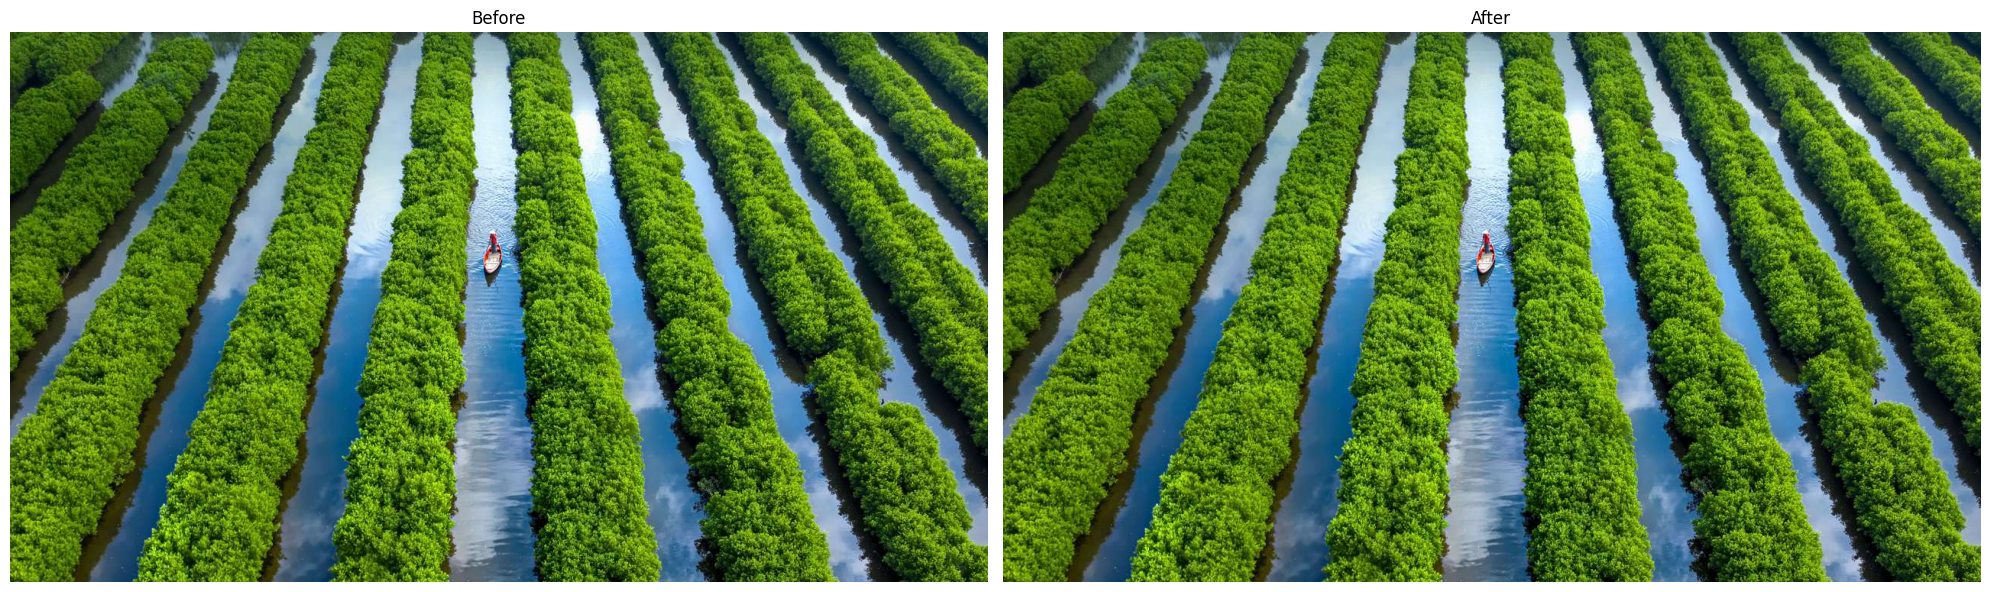

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Before')

axes[1].imshow(zoomed, cmap='gray')
axes[1].axis('off')
axes[1].set_title('After')

plt.tight_layout()
plt.show()

In [ ]:
def gaussian_kernel(size, sigma):
    x = np.linspace(-(size//2), size//2, size)
    kernel = np.exp(-x**2 / (2*sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def boxBlur(image, kernel_size=3):
    image = image.astype(float) / 255.0

    kernel = gaussian_kernel(kernel_size, 100)

    blurred_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=image)
    blurred_image = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=blurred_image)

    return PIL.Image.fromarray((blurred_image * 255).astype(np.uint8))

In [ ]:
new_image1 = boxBlur(img, 15)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title('Before')

axes[1].imshow(new_image1, cmap='gray')
axes[1].axis('off')
axes[1].set_title('After')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(new_image1)
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(new_image2, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.tight_layout()
plt.show()

In [175]:
import os

output_img = PIL.Image.fromarray(zoomed)
output_img.save("output.png")